# Wikipedia Graph Analysis

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import deque, defaultdict
import pandas as pd
import time
import igraph as ig
import random

In [2]:
def create_graph_from_files(ids_file_path, arcs_file_path, max_lines=None, max_nodes=None, max_edges=None):
    """
    Crea il grafo diretto G utilizzando solo le prime max_lines righe del file .arcs e max_nodes nodi.
    Può anche limitare il numero di nodi e archi per migliorare le performance.
    Ritorna G (grafo diretto) e U_G (versione non diretta di G).
    
    - max_lines: Numero massimo di righe da processare (opzionale).
    - max_nodes: Numero massimo di nodi da aggiungere (opzionale).
    - max_edges: Numero massimo di archi da aggiungere (opzionale).
    """
    # Crea un grafo diretto vuoto utilizzando NetworkX
    G = nx.DiGraph()

    # Dizionari per mappare ID dei nodi ai nomi delle pagine e viceversa
    id_to_name = {}
    name_to_id = {}

    # Lettura del file .ids per popolare i dizionari id_to_name e name_to_id
    with open(ids_file_path, 'r', encoding='utf-8') as ids_file:
        for i, line in enumerate(ids_file):
            if max_nodes and i >= max_nodes:  # Interrompi la lettura se il limite di nodi è raggiunto
                break
            name = line.strip()  # Rimuove gli spazi vuoti dal nome della pagina
            id_to_name[i] = name  # Mappa l'ID al nome della pagina
            name_to_id[name] = i  # Mappa il nome al rispettivo ID

    # Lettura del file .arcs per aggiungere gli archi al grafo G, rispettando i limiti opzionali
    edges = []
    edge_count = 0
    with open(arcs_file_path, 'r') as arcs_file:
        for i, line in enumerate(arcs_file):
            if max_lines and i >= max_lines:  # Ferma se raggiunge il numero massimo di righe specificato
                break
            if max_edges and edge_count >= max_edges:  # Ferma se raggiunge il numero massimo di archi
                break
            u, v = map(int, line.strip().split())  # Divide la riga in due ID interi corrispondenti ai nodi
            if max_nodes is None or (u < max_nodes and v < max_nodes):  # Aggiungi l'arco solo se i nodi rientrano nei limiti
                edges.append((u, v))  # Aggiunge l'arco (u, v) alla lista degli archi
                edge_count += 1  # Incrementa il conteggio degli archi aggiunti

    # Aggiunge tutti gli archi al grafo in un solo passaggio per migliorare le prestazioni
    G.add_edges_from(edges)

    # Crea una versione non diretta del grafo G, utile per analisi future
    U_G = G.to_undirected()

    # Ritorna il grafo diretto G, la versione non diretta U(G), e i dizionari id_to_name e name_to_id
    return G, U_G, id_to_name, name_to_id


# Impostazioni per i percorsi dei file e il numero massimo di righe da processare
ids_file_path = 'itwiki-2013.ids'
arcs_file_path = 'itwiki-2013.arcs'
max_lines = 10000000  # Numero massimo di righe da leggere dal file .arcs

# Inizia a misurare il tempo per la creazione del grafo
start_time = time.time()
# Crea il grafo e la sua versione non diretta utilizzando la funzione create_graph_from_files
G, U_G, id_to_name, name_to_id = create_graph_from_files(ids_file_path, arcs_file_path, max_lines)
end_time = time.time()

# Stampa il tempo impiegato per creare i grafi
print(f"Tempo di creazione dei grafi G e U(G): {end_time - start_time:.2f} secondi\n")

# Stampa il numero di nodi e di archi presenti nel grafo G
print(f"Numero di nodi nel grafo: {G.number_of_nodes()}\nNumero di archi nel grafo: {G.number_of_edges()}")

Tempo di creazione dei grafi G e U(G): 78.70 secondi

Numero di nodi nel grafo: 753032
Numero di archi nel grafo: 10000000


#### Question 1/I - Compute the in-degree distribution in G: which are the top-10 pages with largest indegree?

In [3]:
def calculate_degree(graph, degree_type='total'):
    """
    Calcola l'indegree, l'outdegree o il grado totale per ciascun nodo nel grafo e restituisce un dizionario con i valori.
    
    Parametri:
    - graph: Il grafo su cui calcolare i gradi.
    - degree_type: Specifica se calcolare 'in', 'out' o 'total' degree (default è 'total' per grafi non diretti).
    
    Ritorna:
    - Dizionario con i gradi (indegree, outdegree o grado totale) per ciascun nodo.
    """
    # Inizializza un dizionario per memorizzare i gradi per ciascun nodo
    degree_dict = {}
    
    if degree_type == 'out':  # Se si vogliono calcolare gli outdegree
        # Itera su tutti gli archi del grafo e aumenta l'outdegree del nodo u
        for u, v in graph.edges():
            if u in degree_dict:
                degree_dict[u] += 1
            else:
                degree_dict[u] = 1
    elif degree_type == 'in':  # Se si vogliono calcolare gli indegree
        # Itera su tutti gli archi del grafo e aumenta l'indegree del nodo v
        for u, v in graph.edges():
            if v in degree_dict:
                degree_dict[v] += 1
            else:
                degree_dict[v] = 1
    elif degree_type == 'total':  # Se si vuole calcolare il grado totale
        # Itera su tutti gli archi del grafo e aggiorna sia il nodo u che il nodo v
        for u, v in graph.edges():
            if u in degree_dict:
                degree_dict[u] += 1
            else:
                degree_dict[u] = 1
            if v in degree_dict:
                degree_dict[v] += 1
            else:
                degree_dict[v] = 1

    # Assicurati che ogni nodo sia presente nel dizionario, anche quelli senza archi
    for node in graph.nodes():
        if node not in degree_dict:
            degree_dict[node] = 0  # I nodi senza collegamenti hanno grado 0

    # Restituisce il dizionario con i gradi calcolati
    return degree_dict


def print_top_10_degree(degree_dict, id_to_name, degree_type='in'):
    """
    Stampa i primi 10 nodi con il maggior indegree, outdegree o total degree in base al dizionario passato.
    
    Parametri:
    - degree_dict: Dizionario con i valori di grado (indegree/outdegree/total degree).
    - id_to_name: Dizionario che mappa gli ID dei nodi ai nomi per la stampa.
    - degree_type: Tipo di grado ('in', 'out' o 'total') da stampare.
    """
    # Ordina i nodi in base al loro grado in ordine decrescente e seleziona i primi 10
    top_10 = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)[:10]

    # Identifica il nome del tipo di grado da stampare (indegree, outdegree, o total degree)
    if degree_type == 'in':
        degree_name = "indegree"
    elif degree_type == 'out':
        degree_name = "outdegree"
    else:
        degree_name = "total degree"
    
    # Stampa i primi 10 nodi con il maggior grado (in, out, o total)
    print(f"Prime 10 pagine con il maggior {degree_name}:")
    for index, (node_id, degree) in enumerate(top_10, start=1):
        page_name = id_to_name.get(node_id, "Nome non disponibile")  # Recupera il nome della pagina
        print(f"{index}) {page_name}, ID: {node_id}, {degree_name.capitalize()}: {degree}")  # Stampa il risultato

In [4]:
start_time = time.time()  # Registra l'ora di inizio dell'esecuzione
in_degree_dict = calculate_degree(G, degree_type='in')  # Calcola gli indegree del grafo G
end_time = time.time()  # Registra l'ora di fine dell'esecuzione

# Calcola e stampa il tempo impiegato per eseguire l'algoritmo di calcolo degli indegree
print(f"Tempo di esecuzione algoritmo per il calcolo della distribuzione degli indegree in G: {end_time - start_time:.2f} secondi\n")

# Stampa i primi 10 nodi con il maggior indegree utilizzando il dizionario calcolato e la mappatura ID-nome
print_top_10_degree(in_degree_dict, id_to_name, degree_type='in')

Tempo di esecuzione algoritmo per il calcolo della distribuzione degli indegree in G: 4.32 secondi

Prime 10 pagine con il maggior indegree:
1) Stati Uniti d'America, ID: 354122, Indegree: 31362
2) Comuni della Francia, ID: 2939, Indegree: 31205
3) Italia, ID: 396839, Indegree: 27957
4) 2007, ID: 396908, Indegree: 21686
5) 2006, ID: 396907, Indegree: 21075
6) 2008, ID: 396349, Indegree: 20507
7) 2005, ID: 396909, Indegree: 19955
8) 2004, ID: 396905, Indegree: 19767
9) 2009, ID: 396348, Indegree: 19476
10) Germania, ID: 353982, Indegree: 18575


In [5]:
def plot_degree_distribution(degree_dict, degree_type='out'):
    """
    Visualizza la distribuzione dei gradi (indegree, outdegree o totale) e la loro rappresentazione log-log
    fianco a fianco in due grafici.

    Parametri:
    - degree_dict: Dizionario con i valori dei gradi (indegree/outdegree/total).
    - degree_type: Specifica se stampare 'in', 'out' o 'total' degree (default 'out').
    """
    degree_count = {}
    for degree in degree_dict.values():
        degree_count[degree] = degree_count.get(degree, 0) + 1  # Conta quanti nodi hanno un certo grado

    degrees = list(degree_count.keys())  # Gradi unici
    frequencies = [degree_count[degree] for degree in degrees]  # Frequenza per ogni grado

    # Prepara il titolo e le etichette in base al tipo di grado (in, out o total)
    if degree_type == 'in':
        degree_name = "indegree"
    elif degree_type == 'out':
        degree_name = "outdegree"
    else:
        degree_name = "total degree"

    title = f'{degree_name} Distribution'

    # Crea due grafici (subplots) affiancati, uno per la distribuzione e uno per il log-log
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # Grafico a barre della distribuzione dei gradi
    axs[0].bar(degrees, frequencies, color='skyblue', edgecolor='black')
    axs[0].set_xlabel(degree_name)
    axs[0].set_ylabel('Frequency')
    axs[0].set_title(title)
    axs[0].set_xlim([0, 100])  # Limita l'asse x per visualizzare i gradi fino a 100
    axs[0].grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)

    # Grafico log-log per la distribuzione dei gradi
    axs[1].scatter(degrees, frequencies, color='skyblue', edgecolor='black')
    axs[1].set_xscale('log')  # Scala logaritmica per l'asse x
    axs[1].set_yscale('log')  # Scala logaritmica per l'asse y
    axs[1].set_xlabel(f'{degree_name} (log scale)')
    axs[1].set_ylabel('Frequency (log scale)')
    axs[1].set_title(f'{degree_name} Distribution (Log-Log Plot)')
    axs[1].grid(True, which='both', linestyle='--', linewidth=0.7)

    # Ottimizza il layout per evitare sovrapposizioni
    plt.tight_layout()
    plt.show()

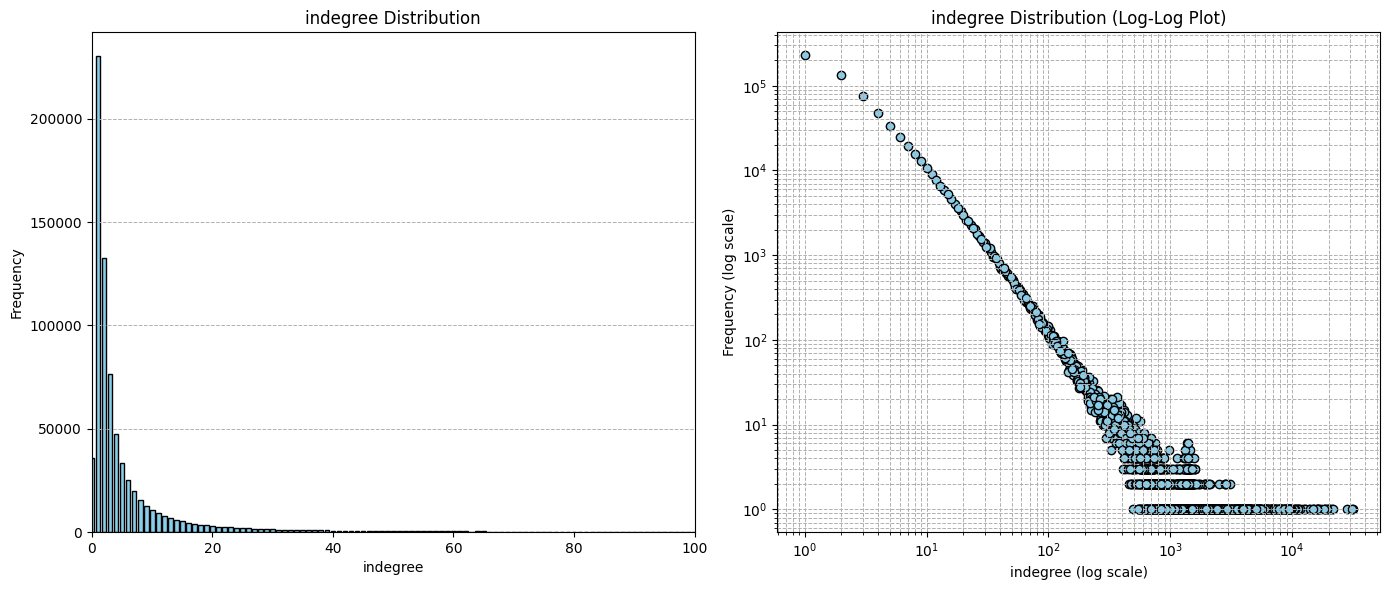

In [6]:
plot_degree_distribution(in_degree_dict, degree_type='in')

#### Question 1/II - Compute the out-degree distribution in G: which are the top-10 pages with largest outdegree?

In [7]:
start_time = time.time()  # Avvia il timer per misurare il tempo di esecuzione
out_degree_dict = calculate_degree(G, degree_type='out')  # Calcola la distribuzione degli outdegree nel grafo G
end_time = time.time()  # Registra il tempo dopo l'esecuzione

# Stampa il tempo impiegato per calcolare la distribuzione degli outdegree
print(f"Tempo di esecuzione algoritmo per il calcolo della distribuzione degli outdegree in G: {end_time - start_time:.2f} secondi\n")

# Stampa le prime 10 pagine con il maggior outdegree utilizzando il dizionario calcolato
print_top_10_degree(out_degree_dict, id_to_name, degree_type='out')

Tempo di esecuzione algoritmo per il calcolo della distribuzione degli outdegree in G: 2.34 secondi

Prime 10 pagine con il maggior outdegree:
1) Città dell'India, ID: 261576, Outdegree: 5212
2) Nati nel 1981, ID: 395575, Outdegree: 3256
3) Nati nel 1985, ID: 395611, Outdegree: 3250
4) Nati nel 1983, ID: 395769, Outdegree: 3235
5) Nati nel 1984, ID: 395650, Outdegree: 3231
6) Nati nel 1980, ID: 395546, Outdegree: 3120
7) Nati nel 1979, ID: 395354, Outdegree: 3007
8) Nati nel 1987, ID: 395324, Outdegree: 3004
9) Nati nel 1988, ID: 395593, Outdegree: 2909
10) Nati nel 1978, ID: 395685, Outdegree: 2821


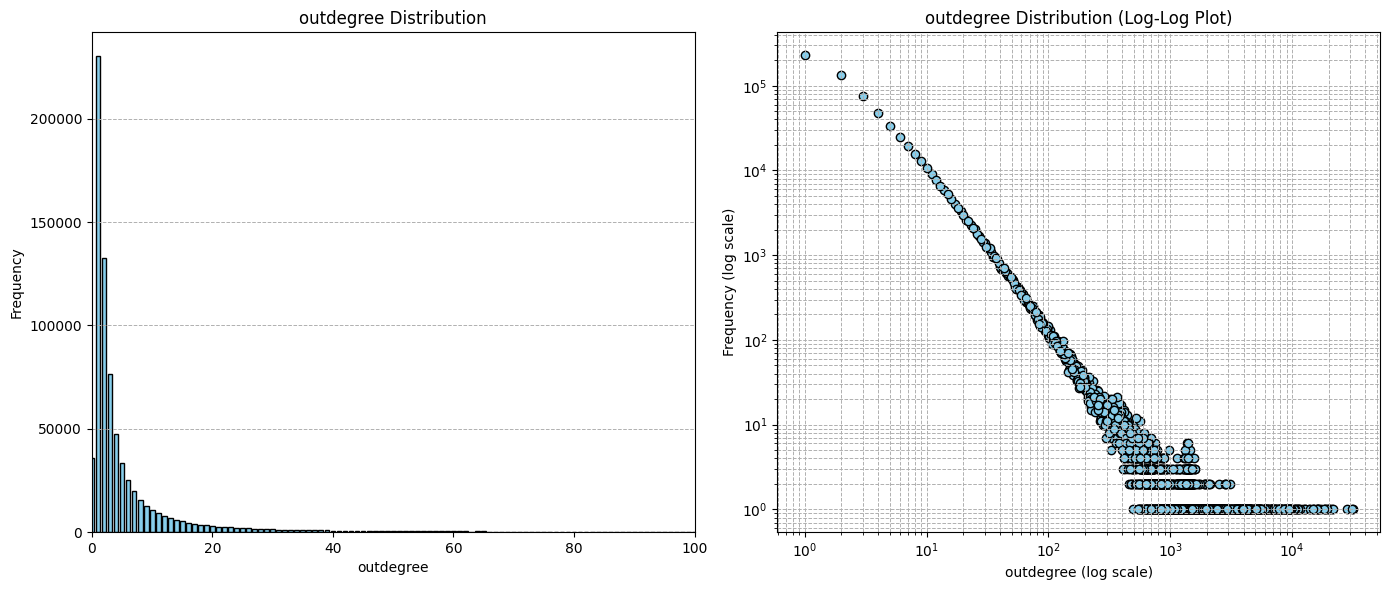

In [8]:
plot_degree_distribution(in_degree_dict, degree_type='out')

#### Question 1/III - Considering the undirected graph of the graph built U(G), compute the degree distribution: which are the top-10 pages with largest degree?

In [9]:
# Dato che parliamo di un grafo non diretto, il degree è la somma di archi in entrata e in uscita per ciascun nodo
# Calcola la distribuzione dei gradi (degree) nel grafo non diretto U_G
start_time = time.time()  # Avvia il timer per misurare il tempo di esecuzione
degree_dict = calculate_degree(U_G, degree_type='total')  # 'total' rappresenta il grado complessivo nel grafo non diretto
end_time = time.time()  # Registra il tempo dopo l'esecuzione

# Stampa il tempo impiegato per calcolare la distribuzione dei gradi (degree)
print(f"Tempo di esecuzione algoritmo per il calcolo della distribuzione del degree in U(G): {end_time - start_time:.2f} secondi\n")

# Stampa le prime 10 pagine con il grado complessivo maggiore nel grafo non diretto
print_top_10_degree(degree_dict, id_to_name, degree_type='total')

Tempo di esecuzione algoritmo per il calcolo della distribuzione del degree in U(G): 8.88 secondi

Prime 10 pagine con il maggior total degree:
1) Stati Uniti d'America, ID: 354122, Total degree: 31800
2) Comuni della Francia, ID: 2939, Total degree: 31496
3) Italia, ID: 396839, Total degree: 27957
4) 2007, ID: 396908, Total degree: 21686
5) 2006, ID: 396907, Total degree: 21075
6) 2008, ID: 396349, Total degree: 20507
7) 2005, ID: 396909, Total degree: 19955
8) 2004, ID: 396905, Total degree: 19767
9) 2009, ID: 396348, Total degree: 19476
10) Germania, ID: 353982, Total degree: 18837


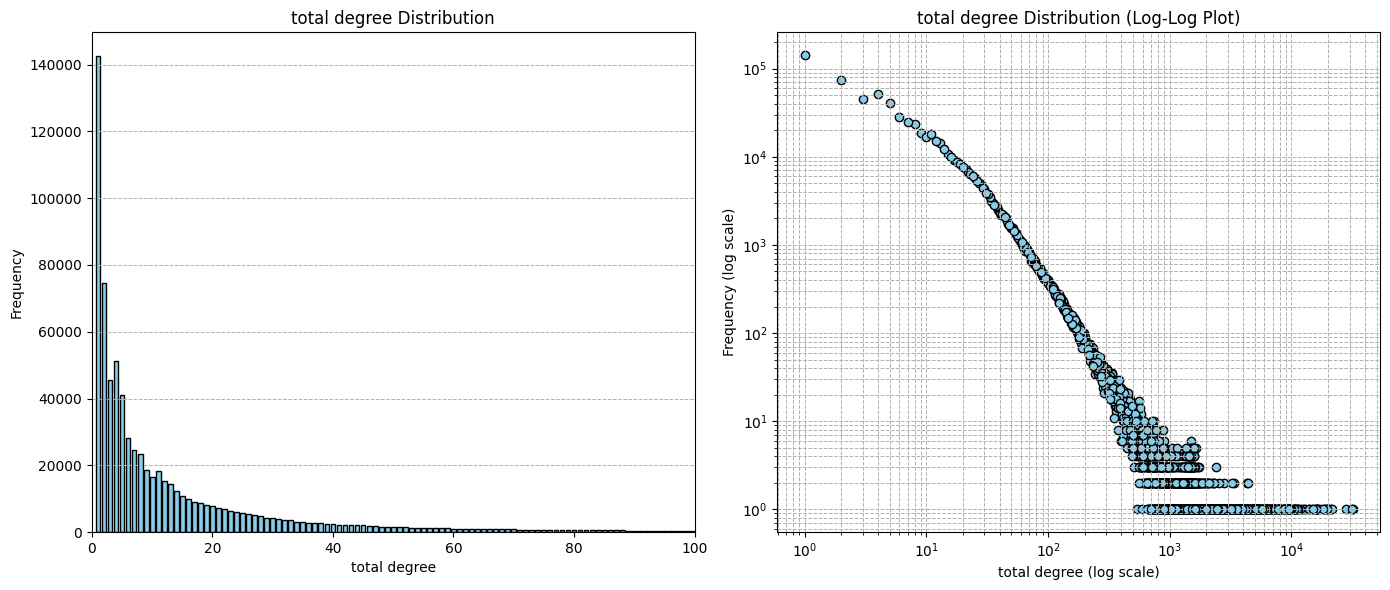

In [10]:
plot_degree_distribution(degree_dict, degree_type='total')

#### Question 2/A - Considering U(G) and restricting to its largest connected component V', compute exactly the diameter of the graph induced by the vertices in V'. Repeat removing from the graphs the nodes whose name contains the string "disambigua".

In [11]:
def find_largest_connected_component(graph):
    """
    Trova la componente connessa più grande in un grafo non diretto usando BFS.
    Restituisce il sottografo della LCC.
    """
    def bfs_component(start_node, visited):
        queue = deque([start_node])  # Inizializza la coda con il nodo di partenza
        component = set([start_node])  # La componente connessa inizia con il nodo di partenza

        while queue:
            node = queue.popleft()  # Estrai il nodo dalla coda
            for neighbor in graph.neighbors(node):  # Itera sui vicini del nodo
                if neighbor not in visited:  # Se il vicino non è stato visitato
                    visited.add(neighbor)  # Aggiungilo ai nodi visitati
                    component.add(neighbor)  # Aggiungilo alla componente
                    queue.append(neighbor)  # Aggiungi il vicino alla coda
        return component

    visited = set()  # Insieme dei nodi già visitati
    largest_component = set()  # Componente connessa più grande

    for node in graph.nodes():  # Itera su tutti i nodi del grafo
        if node not in visited:  # Se il nodo non è stato visitato
            visited.add(node)  # Aggiungi il nodo ai visitati
            component = bfs_component(node, visited)  # Trova la componente connessa che include il nodo
            if len(component) > len(largest_component):  # Aggiorna la componente più grande
                largest_component = component

    return graph.subgraph(largest_component).copy()  # Restituisci il sottografo della LCC

def bfs_eccentricity(graph, start_node):
    """
    Calcola l'eccentricità di un nodo usando BFS.
    Restituisce l'eccentricità e il nodo più distante.
    """
    visited = {start_node: 0}  # Dizionario per memorizzare la distanza dal nodo di partenza
    queue = deque([start_node])  # Inizializza la coda con il nodo di partenza
    farthest_node = start_node  # Nodo più distante inizialmente è lo stesso nodo di partenza
    max_distance = 0  # Distanza massima inizializzata a 0

    while queue:
        node = queue.popleft()  # Estrai il nodo dalla coda
        current_distance = visited[node]  # Ottieni la distanza attuale dal nodo di partenza

        for neighbor in graph.neighbors(node):  # Itera sui vicini del nodo
            if neighbor not in visited:  # Se il vicino non è stato visitato
                visited[neighbor] = current_distance + 1  # Aggiungi il vicino con la distanza aggiornata
                queue.append(neighbor)  # Aggiungi il vicino alla coda

                # Aggiorna la distanza massima e il nodo più distante
                if visited[neighbor] > max_distance:
                    max_distance = visited[neighbor]
                    farthest_node = neighbor

    return max_distance, farthest_node  # Restituisce la distanza massima e il nodo più distante

def bidirectional_bfs(graph, start_node, target_node):
    """
    Implementa una BFS bidirezionale tra start_node e target_node.
    Restituisce la distanza minima tra i due nodi o -1 se non sono connessi.
    """
    if start_node == target_node:
        return 0  # Se i nodi coincidono, la distanza è 0

    # Inizializza le strutture dati per la BFS da entrambi i lati
    start_visited = {start_node: 0}
    target_visited = {target_node: 0}
    
    start_queue = deque([start_node])
    target_queue = deque([target_node])
    
    while start_queue and target_queue:
        # Espansione dalla parte del nodo di partenza
        if start_queue:
            node = start_queue.popleft()
            current_distance = start_visited[node]

            for neighbor in graph.neighbors(node):
                if neighbor in target_visited:  # Se l'espansione si incrocia con l'altra parte
                    return current_distance + target_visited[neighbor] + 1  # Restituisce la distanza minima
                if neighbor not in start_visited:  # Aggiungi il vicino se non visitato
                    start_visited[neighbor] = current_distance + 1
                    start_queue.append(neighbor)

        # Espansione dalla parte del nodo di arrivo
        if target_queue:
            node = target_queue.popleft()
            current_distance = target_visited[node]

            for neighbor in graph.neighbors(node):
                if neighbor in start_visited:  # Se l'espansione si incrocia con l'altra parte
                    return current_distance + start_visited[neighbor] + 1  # Restituisce la distanza minima
                if neighbor not in target_visited:  # Aggiungi il vicino se non visitato
                    target_visited[neighbor] = current_distance + 1
                    target_queue.append(neighbor)

    return -1  # Restituisce -1 se non esiste un percorso tra i due nodi


def bfs_fringe(graph, start_node, depth):
    """
    Trova i nodi a distanza 'depth' dal nodo di partenza usando BFS.
    """
    visited = {start_node: 0}  # Dizionario per memorizzare la distanza dei nodi
    queue = deque([(start_node, 0)])  # Coda con il nodo e la distanza iniziale
    fringe = set()  # Insieme per memorizzare i nodi alla distanza desiderata

    while queue:
        node, dist = queue.popleft()

        if dist == depth:
            fringe.add(node)  # Aggiungi i nodi che si trovano alla distanza richiesta
        elif dist < depth:  # Continua l'espansione finché non superiamo la distanza richiesta
            for neighbor in graph.neighbors(node):
                if neighbor not in visited:
                    visited[neighbor] = dist + 1  # Aggiorna la distanza
                    queue.append((neighbor, dist + 1))  # Aggiungi il vicino alla coda

    return fringe  # Restituisce i nodi a distanza 'depth'

def ifub_diameter(graph):
    """
    Calcola il diametro del grafo usando l'algoritmo iFub ottimizzato con BFS bidirezionale.
    """
    # Step 1: Inizia con un nodo qualsiasi
    start_node = list(graph.nodes())[0]

    # Step 2: Calcola l'eccentricità iniziale con BFS e trova il nodo più lontano
    _, farthest_node = bfs_eccentricity(graph, start_node)

    # Step 3: Imposta i limiti iniziali
    lb, farthest_node = bfs_eccentricity(graph, farthest_node)  # Limite inferiore
    ub = 2 * lb  # Limite superiore iniziale
    i = lb

    while ub > lb:
        # Step 4: Trova la fringe a distanza 'i' dal nodo più lontano
        fringe_nodes = bfs_fringe(graph, farthest_node, i)

        # Step 5: Trova l'eccentricità massima tra i nodi nella fringe
        max_eccentricity_in_fringe = 0
        for node in fringe_nodes:
            eccentricity = bidirectional_bfs(graph, farthest_node, node)
            max_eccentricity_in_fringe = max(max_eccentricity_in_fringe, eccentricity)

        # Aggiorna i limiti
        lb = max(lb, max_eccentricity_in_fringe)
        ub = 2 * (i - 1)
        i -= 1

    return lb  # Il diametro si trova quando i limiti convergono

def remove_disambigua_nodes(graph, id_to_name):
    """
    Rimuove i nodi che contengono 'disambigua' nel nome e ritorna il grafo ridotto.
    """
    nodes_to_remove = [node for node in graph.nodes() if "disambigua" in id_to_name.get(node, "").lower()]  # Filtra i nodi da rimuovere
    graph.remove_nodes_from(nodes_to_remove)  # Rimuove i nodi dal grafo
    return graph  # Restituisce il grafo modificato


def pipeline(graph, id_to_name):
    """
    Calcola il diametro del grafo con e senza nodi 'disambigua'.
    """
    # Calcolo con i nodi 'disambigua'
    start_time = time.time()  # Misura il tempo di esecuzione
    print("Calcolo con nodi 'disambigua'...")
    largest_cc = find_largest_connected_component(graph)  # Trova la LCC
    diameter = ifub_diameter(largest_cc)  # Calcola il diametro
    print(f"Diametro: {diameter}")
    end_time = time.time() 
    print(f"Tempo di esecuzione: {end_time - start_time:.2f} secondi\n")
    
    # Calcolo senza nodi 'disambigua'
    start_time = time.time()  # Misura il tempo di esecuzione
    print("Rimozione dei nodi 'disambigua' e ricalcolo...")
    graph_cleaned = remove_disambigua_nodes(graph.copy(), id_to_name)  # Rimuove i nodi 'disambigua'
    largest_cc = find_largest_connected_component(graph_cleaned)  # Trova la LCC nel grafo pulito
    diameter = ifub_diameter(largest_cc)  # Calcola il diametro
    print(f'Diametro (senza nodi disambigua): {diameter}')
    end_time = time.time() 
    print(f"Tempo di esecuzione: {end_time - start_time:.2f} secondi\n")

pipeline(U_G, id_to_name)  # Esegue la pipeline sul grafo U_G

Calcolo con nodi 'disambigua'...
Diametro: 12
Tempo di esecuzione: 447.84 secondi

Rimozione dei nodi 'disambigua' e ricalcolo...
Diametro (senza nodi disambigua): 12
Tempo di esecuzione: 722.30 secondi



#### Question 3/1 - Considering U(G), build an algorithm to find a Maximal Clique containing at least 3 elements. Can you find two of them instead of only one?

In [12]:
def bron_kerbosch(R, P, X, graph, maximal_cliques, max_cliques_needed=2):
    """
    Algoritmo Bron-Kerbosch modificato per trovare cliques massimali.
    
    Parametri:
    - R: Insieme dei nodi che sono già inclusi nella clique corrente.
    - P: Insieme dei nodi candidati che possono ancora essere aggiunti alla clique.
    - X: Insieme dei nodi che non possono più essere inclusi nella clique (già processati).
    - graph: Il grafo su cui viene eseguito l'algoritmo.
    - maximal_cliques: Lista dove vengono salvate le cliques massimali trovate.
    - max_cliques_needed: Numero massimo di cliques da trovare (valore di default 2).
    
    Logica:
    - L'algoritmo continua finché non ci sono più candidati in P o nodi in X.
    - Se la clique formata (R) ha almeno 3 nodi ed è massimale, la aggiunge a `maximal_cliques`.
    - Il pivot viene scelto da P ∪ X e i nodi di P che non sono vicini del pivot vengono processati.
    - Ricorsivamente, vengono trovate tutte le cliques massimali.
    """

    # Se P e X sono vuoti, significa che abbiamo trovato una clique massimale.
    if not P and not X:
        if len(R) >= 3:  # Consideriamo solo cliques con almeno 3 nodi (clique non banali)
            maximal_cliques.append(R)  # Aggiungi la clique massimale trovata alla lista
        return

    # Se abbiamo già trovato il numero massimo di cliques richieste, fermati.
    if len(maximal_cliques) >= max_cliques_needed:
        return

    # Scegli un nodo pivot da P ∪ X per limitare il numero di ricorsioni.
    pivot = next(iter(P.union(X)), None)  # Prende un nodo qualsiasi da P ∪ X
    if pivot is None:  # Se non esiste un pivot (caso limite), termina
        return

    # Processa i nodi in P che non sono vicini del pivot
    # L'algoritmo evita i nodi che sono vicini del pivot per migliorare l'efficienza.
    for node in P - set(graph.neighbors(pivot)):
        # Ricorsivamente chiama Bron-Kerbosch aggiornando R, P, e X
        # Unisci `node` con la clique corrente (R), e aggiorna i candidati (P) e i nodi esclusi (X)
        bron_kerbosch(
            R.union([node]),  # Aggiungi il nodo corrente alla clique R
            P.intersection(graph.neighbors(node)),  # Limita P ai vicini del nodo aggiunto
            X.intersection(graph.neighbors(node)),  # Limita X ai vicini del nodo aggiunto
            graph, maximal_cliques, max_cliques_needed
        )
        P.remove(node)  # Rimuovi il nodo processato da P
        X.add(node)     # Aggiungi il nodo processato a X (ora è escluso)

def find_maximal_cliques_bron_kerbosch(graph, id_to_name, max_cliques_needed=2):
    """
    Funzione che avvia l'algoritmo Bron-Kerbosch per trovare più cliques massimali non banali.

    Parametri:
    - graph: Il grafo in cui si vogliono trovare le cliques massimali.
    - id_to_name: Dizionario che mappa gli ID dei nodi ai nomi per la stampa.
    - max_cliques_needed: Numero massimo di cliques massimali da trovare.

    Ritorna:
    - Una lista con le cliques massimali trovate.
    """
    R = set()  # Insieme iniziale vuoto (clique corrente)
    P = set(graph.nodes())  # Tutti i nodi sono candidati iniziali per essere inclusi nella clique
    X = set()  # Insieme vuoto, non ci sono nodi esclusi all'inizio
    
    maximal_cliques = []  # Lista per memorizzare tutte le cliques massimali trovate

    # Avvia l'algoritmo Bron-Kerbosch per trovare le cliques massimali
    bron_kerbosch(R, P, X, graph, maximal_cliques, max_cliques_needed)

    # Stampa le cliques massimali trovate, convertendo gli ID nei nomi
    for idx, clique in enumerate(maximal_cliques, start=1):
        clique_names = [id_to_name[node] for node in clique]  # Converte gli ID dei nodi nei loro nomi
        print(f"Clique massimale {idx}: {clique_names}")  # Stampa la clique massimale con i nomi dei nodi

    return maximal_cliques  # Restituisce la lista delle cliques massimali trovate

# Esegui l'algoritmo per trovare due cliques massimali con i nomi dei nodi
start_time = time.time()
maximal_cliques = find_maximal_cliques_bron_kerbosch(U_G, id_to_name, max_cliques_needed=2)
end_time = time.time() 
print(f"\nTempo di esecuzione: {end_time - start_time:.2f} secondi")

Clique massimale 1: ['Cabra de Mora', 'Spagna', 'Aragona', 'Formiche Alto', 'Comunità autonome della Spagna', 'El Castellar']
Clique massimale 2: ['Cabra de Mora', 'El Castellar', 'Alcalá de la Selva']

Tempo di esecuzione: 10.98 secondi


#### Question 4 - Repeat the questions using enwiki-2023 dataset and igraph

#### 4.1/I - Compute the in-degree distribution in G: which are the top-10 pages with largest indegree?

In [13]:
def create_graph_from_files_igraph(ids_file_path, arcs_file_path, max_lines=None, max_nodes=None, max_edges=None):
    """
    Crea il grafo diretto G utilizzando un limite opzionale per max_lines righe del file .arcs.
    Può anche limitare il numero di nodi e archi nel grafo per migliorare le performance.
    Ritorna G (grafo diretto) e U_G (versione non diretta di G).
    
    - max_lines: Numero massimo di righe da processare (opzionale).
    - max_nodes: Numero massimo di nodi da aggiungere (opzionale).
    - max_edges: Numero massimo di archi da aggiungere (opzionale).
    """
    # Crea il grafo vuoto con direzione (orientato)
    G = ig.Graph(directed=True)
    
    # Dizionari per mappare ID dei nodi ai nomi delle pagine e viceversa
    id_to_name = {}  # Mappa l'ID al nome della pagina
    name_to_id = {}  # Mappa il nome al rispettivo ID

    # Lettura del file .ids per popolare i dizionari id_to_name e name_to_id
    with open(ids_file_path, 'r', encoding='utf-8') as ids_file:
        for i, line in enumerate(ids_file):
            if max_nodes and i >= max_nodes:  # Se abbiamo raggiunto il limite di nodi specificato, fermati
                break
            name = line.strip()  # Rimuove eventuali spazi bianchi
            id_to_name[i] = name  # Aggiunge l'ID come chiave e il nome della pagina come valore
            name_to_id[name] = i  # Aggiunge il nome della pagina come chiave e l'ID come valore
            G.add_vertex(name=name)  # Aggiunge il nodo corrispondente al grafo G

    # Lettura del file .arcs per aggiungere gli archi al grafo G, limitato a max_lines righe
    edges = []  # Lista per memorizzare gli archi
    edge_count = 0  # Contatore per gli archi aggiunti
    with open(arcs_file_path, 'r') as arcs_file:
        for i, line in enumerate(arcs_file):
            if max_lines and i >= max_lines:  # Se max_lines è specificato e raggiunto, fermati
                break
            if max_edges and edge_count >= max_edges:  # Se raggiungiamo il numero massimo di archi, fermati
                break
            u, v = map(int, line.strip().split())  # Divide la riga in due ID di nodi (u, v)
            if u < len(G.vs) and v < len(G.vs):  # Aggiungi l'arco solo se entrambi i nodi sono validi
                edges.append((u, v))  # Aggiungi l'arco alla lista degli archi
                edge_count += 1  # Incrementa il contatore degli archi

    # Aggiungi tutti gli archi in una volta (batch) al grafo
    G.add_edges(edges)

    # Crea la versione non diretta del grafo G per future analisi
    U_G = G.as_undirected()

    return G, U_G, id_to_name, name_to_id  # Restituisce il grafo diretto G, il grafo non diretto U_G e i dizionari

# Impostazioni dei percorsi e limiti per il file .ids e .arcs
ids_file_path = 'enwiki-2023.ids'
arcs_file_path = 'enwiki-2023.arcs'
max_lines = 10000000  # Numero massimo di righe di archi da processare
max_nodes = 75000  # Numero massimo di nodi da aggiungere

# Misura il tempo per creare i grafi G e U_G
start_time = time.time()
# Crea il grafo utilizzando solo i primi max_lines archi e i primi max_nodes nodi
G, U_G, id_to_name, name_to_id = create_graph_from_files_igraph(ids_file_path, arcs_file_path, max_lines, max_nodes)
end_time = time.time() 
print(f"Tempo di creazione dei grafi G e U(G): {end_time - start_time:.2f} secondi\n")

# Stampa il numero di nodi e archi presenti nel grafo diretto G
print(f"Numero di nodi nel grafo: {len(G.vs)}\nNumero di archi nel grafo: {len(G.es)}")

Tempo di creazione dei grafi G e U(G): 18.11 secondi

Numero di nodi nel grafo: 75000
Numero di archi nel grafo: 444147


In [14]:
def calculate_degree_igraph(graph, degree_type='total'):
    """
    Calcola l'indegree, l'outdegree o il grado totale per ciascun nodo nel grafo e restituisce un dizionario con i valori.
    
    Parametri:
    - graph: Il grafo su cui calcolare i gradi (usando igraph).
    - degree_type: Specifica se calcolare 'in', 'out' o 'total' degree (default è 'total' per grafi non diretti).
    
    Ritorna:
    - Dizionario con i gradi (indegree, outdegree o grado totale) per ciascun nodo.
    """
    # Se l'utente chiede l'outdegree (valido per grafi diretti)
    if degree_type == 'out':  
        degrees = graph.outdegree()  # Ottiene l'outdegree per ciascun nodo con igraph
    # Se l'utente chiede l'indegree (valido per grafi diretti)
    elif degree_type == 'in':  
        degrees = graph.indegree()  # Ottiene l'indegree per ciascun nodo con igraph
    # Per grafi non diretti, calcola il grado totale
    elif degree_type == 'total':  
        degrees = graph.degree()  # Ottiene il grado totale con igraph

    # Crea un dizionario che associa l'indice di ogni nodo (v.index) al grado corrispondente
    degree_dict = {v.index: degree for v, degree in zip(graph.vs, degrees)}
    
    return degree_dict  # Restituisce il dizionario dei gradi per ciascun nodo

# Misura il tempo per calcolare l'indegree nel grafo G
start_time = time.time()
in_degree_dict = calculate_degree_igraph(G, degree_type='in')
end_time = time.time() 
print(f"Tempo di esecuzione algoritmo per il calcolo della distribuzione degli indegree in G: {end_time - start_time:.2f} secondi\n")

# Stampa i primi 10 nodi con il maggior indegree
print_top_10_degree(in_degree_dict, id_to_name, degree_type='in')

Tempo di esecuzione algoritmo per il calcolo della distribuzione degli indegree in G: 0.17 secondi

Prime 10 pagine con il maggior indegree:
1) Mexico, ID: 53706, Indegree: 4508
2) Iran, ID: 5100, Indegree: 3665
3) Mexico City, ID: 53412, Indegree: 3034
4) Romanization, ID: 5090, Indegree: 2912
5) Ukraine, ID: 74307, Indegree: 2307
6) Institutional Revolutionary Party, ID: 54489, Indegree: 1388
7) Kohgiluyeh and Boyer-Ahmad province, ID: 4877, Indegree: 1366
8) Veracruz, ID: 53068, Indegree: 1229
9) Nicaragua, ID: 59551, Indegree: 1194
10) Verkhovna Rada, ID: 72544, Indegree: 1121


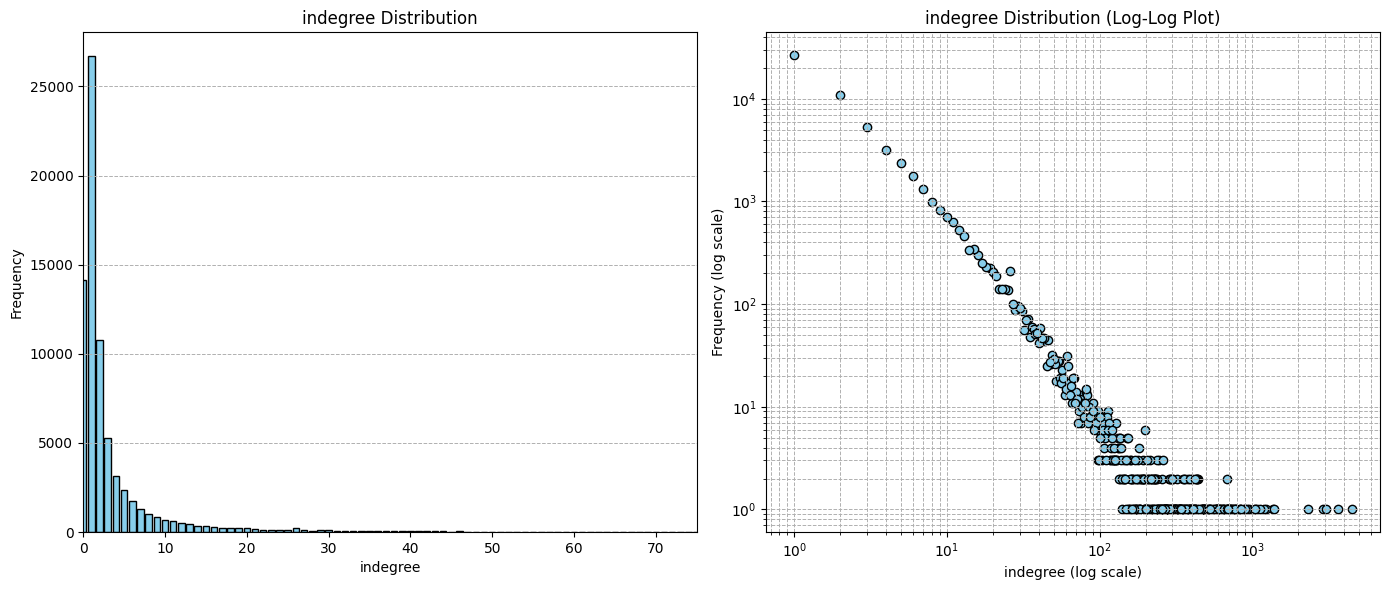

In [15]:
def plot_degree_distribution_igraph(degree_dict, degree_type='out'):
    """
    Visualizza la distribuzione dei gradi (indegree o outdegree) e la loro rappresentazione log-log
    fianco a fianco in due grafici, utilizzando igraph.
    
    Parametri:
    - degree_dict: Dizionario con i valori dei gradi (indegree/outdegree).
    - degree_type: Specifica se stampare 'in' o 'out' degree (default 'out').
    """
    # Crea un dizionario che conta la frequenza di ciascun grado
    degree_count = {}
    for degree in degree_dict.values():
        degree_count[degree] = degree_count.get(degree, 0) + 1  # Incrementa il conteggio del grado

    # Lista dei gradi unici e delle loro frequenze
    degrees = list(degree_count.keys())  # Gradi unici
    frequencies = [degree_count[degree] for degree in degrees]  # Frequenza per ogni grado

    # Determina il tipo di grado e imposta il titolo del grafico
    # Prepara il titolo e le etichette in base al tipo di grado (in, out o total)
    if degree_type == 'in':
        degree_name = "indegree"
    elif degree_type == 'out':
        degree_name = "outdegree"
    else:
        degree_name = "total degree"
    title = f'{degree_name} Distribution'
    
    # Crea due sottoplot: uno per il grafico a barre e uno per il log-log plot
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # Grafico a barre della distribuzione dei gradi
    axs[0].bar(degrees, frequencies, color='skyblue', edgecolor='black')
    axs[0].set_xlabel(degree_name)
    axs[0].set_ylabel('Frequency')
    axs[0].set_title(title)
    axs[0].set_xlim([0, 75])  # Limita l'asse x per evitare eccessiva estensione (adattabile ai dati)
    axs[0].grid(True, which='both', axis='y', linestyle='--', linewidth=0.7)

    # Grafico log-log della distribuzione dei gradi
    axs[1].scatter(degrees, frequencies, color='skyblue', edgecolor='black')
    axs[1].set_xscale('log')  # Scala logaritmica per l'asse x
    axs[1].set_yscale('log')  # Scala logaritmica per l'asse y
    axs[1].set_xlabel(f'{degree_name} (log scale)')
    axs[1].set_ylabel('Frequency (log scale)')
    axs[1].set_title(f'{degree_name} Distribution (Log-Log Plot)')
    axs[1].grid(True, which='both', linestyle='--', linewidth=0.7)

    # Ottimizza il layout e mostra i grafici
    plt.tight_layout()
    plt.show()

# Esegui la funzione per visualizzare la distribuzione degli indegree nel grafo
plot_degree_distribution_igraph(in_degree_dict, degree_type='in')

#### 4.1/II - Compute the out-degree distribution in G: which are the top-10 pages with largest outdegree?

In [16]:
start_time = time.time()  # Inizio del timer per misurare il tempo di esecuzione

# Calcola la distribuzione degli outdegree per ciascun nodo nel grafo G
out_degree_dict = calculate_degree_igraph(G, degree_type='out')

end_time = time.time()  # Fine del timer
# Stampa il tempo totale impiegato per calcolare gli outdegree
print(f"Tempo di esecuzione algoritmo per il calcolo della distribuzione degli outdegree in G: {end_time - start_time:.2f} secondi\n")

# Stampa i primi 10 nodi con il maggior outdegree utilizzando la funzione print_top_10_degree
print_top_10_degree(out_degree_dict, id_to_name, degree_type='out')

Tempo di esecuzione algoritmo per il calcolo della distribuzione degli outdegree in G: 0.17 secondi

Prime 10 pagine con il maggior outdegree:
1) List of cities, towns and villages in Kohgiluyeh and Boyer-Ahmad Province, ID: 4878, Outdegree: 1301
2) List of cities, towns and villages in Chaharmahal and Bakhtiari Province, ID: 3275, Outdegree: 771
3) List of places in Mexico named after people, ID: 53177, Outdegree: 676
4) List of Streptomyces species, ID: 42897, Outdegree: 617
5) Municipalities of Armenia, ID: 35257, Outdegree: 596
6) Communes of the Doubs department, ID: 24565, Outdegree: 567
7) List of populated places in Elazığ Province, ID: 18799, Outdegree: 560
8) Index of Nicaragua-related articles, ID: 59596, Outdegree: 556
9) Index of Mexico-related articles, ID: 53099, Outdegree: 523
10) Communes of the Calvados department, ID: 15243, Outdegree: 517


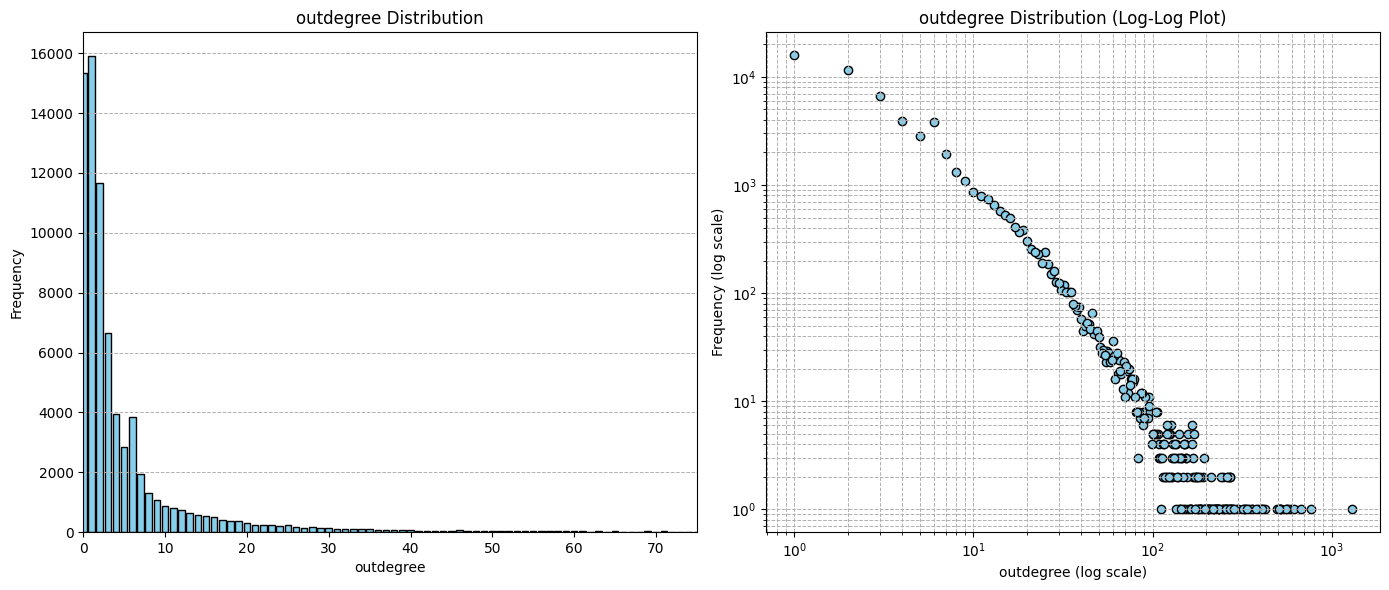

In [17]:
plot_degree_distribution_igraph(out_degree_dict, degree_type='out')

#### 4.1/III - Considering the undirected graph of the graph built U(G), compute the degree distribution: which are the top-10 pages with largest degree?

In [18]:
start_time = time.time()  # Inizio del timer per misurare il tempo di esecuzione

# Calcola la distribuzione del degree totale per ciascun nodo nel grafo non diretto U_G
degree_dict = calculate_degree_igraph(U_G, degree_type='total')

end_time = time.time()  # Fine del timer
# Stampa il tempo totale impiegato per calcolare la distribuzione dei gradi
print(f"Tempo di esecuzione algoritmo per il calcolo della distribuzione del degree in U(G): {end_time - start_time:.2f} secondi\n")

# Stampa i primi 10 nodi con il maggior degree totale utilizzando la funzione print_top_10_degree
print_top_10_degree(degree_dict, id_to_name, degree_type='total')

Tempo di esecuzione algoritmo per il calcolo della distribuzione del degree in U(G): 0.18 secondi

Prime 10 pagine con il maggior total degree:
1) Mexico, ID: 53706, Total degree: 4680
2) Iran, ID: 5100, Total degree: 3666
3) Mexico City, ID: 53412, Total degree: 3089
4) Romanization, ID: 5090, Total degree: 2912
5) Ukraine, ID: 74307, Total degree: 2343
6) Institutional Revolutionary Party, ID: 54489, Total degree: 1450
7) Kohgiluyeh and Boyer-Ahmad province, ID: 4877, Total degree: 1368
8) List of cities, towns and villages in Kohgiluyeh and Boyer-Ahmad Province, ID: 4878, Total degree: 1301
9) Veracruz, ID: 53068, Total degree: 1278
10) Nicaragua, ID: 59551, Total degree: 1224


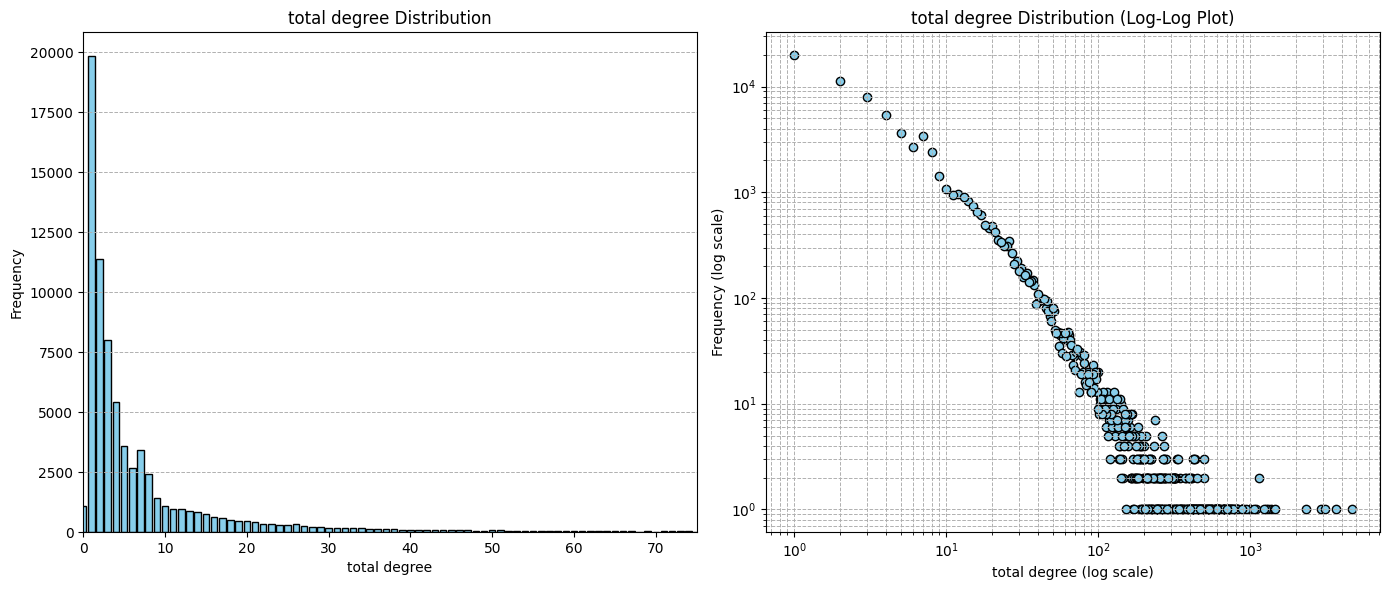

In [19]:
plot_degree_distribution_igraph(degree_dict, degree_type='total')

#### 4.2/A - Considering U(G) and restricting to its largest connected component V', compute exactly the diameter of the graph induced by the vertices in V'. Repeat removing from the graphs the nodes whose name contains the string "disambigua".

In [20]:
# Funzione per trovare la componente connessa più grande
def find_largest_connected_component_igraph(graph):
    """
    Trova la componente connessa più grande in un grafo non diretto usando igraph.
    Restituisce il sottografo della LCC.
    """
    # Trova le componenti connesse debolmente nel grafo
    components = graph.connected_components(mode="WEAK")
    # Restituisce la componente più grande (LCC)
    largest_component = components.giant()  
    return largest_component  # Restituisce il sottografo della componente più grande

# Funzione per calcolare l'eccentricità di un nodo usando igraph
def bfs_eccentricity_igraph(graph, start_node):
    """
    Calcola l'eccentricità di un nodo usando BFS con igraph.
    Restituisce l'eccentricità e il nodo più distante.
    """
    # Calcola tutte le distanze dal nodo di partenza
    shortest_paths = graph.distances(source=start_node)[0]
    # Trova la distanza massima
    max_distance = max(shortest_paths)
    # Trova il nodo più lontano
    farthest_node = shortest_paths.index(max_distance)
    return max_distance, farthest_node  # Restituisce la distanza massima e il nodo più lontano

# Funzione per BFS bidirezionale semplificata per trovare la distanza tra due nodi
def bidirectional_bfs_igraph(graph, start_node, target_node):
    """
    Implementa una BFS bidirezionale tra start_node e target_node in igraph.
    Restituisce la distanza minima tra i due nodi o -1 se non sono connessi.
    """
    if start_node == target_node:
        return 0  # La distanza tra un nodo e se stesso è 0

    # Calcola la distanza minima usando igraph
    shortest_paths = graph.distances(source=start_node, target=target_node)[0][0]
    # Restituisce la distanza o -1 se non esiste un percorso
    return shortest_paths if shortest_paths != float('inf') else -1

# Funzione per BFS fringe (nodi a distanza 'depth')
def bfs_fringe_igraph(graph, start_node, depth):
    """
    Trova i nodi a distanza 'depth' dal nodo di partenza usando BFS con igraph.
    """
    # Calcola tutte le distanze dal nodo di partenza
    all_shortest_paths = graph.distances(source=start_node)[0]
    # Seleziona i nodi che si trovano a distanza esattamente 'depth'
    fringe_nodes = [node for node, distance in enumerate(all_shortest_paths) if distance == depth]
    return fringe_nodes  # Restituisce la lista dei nodi trovati alla distanza 'depth'

# Algoritmo iFub ottimizzato per calcolare il diametro con igraph
def ifub_diameter_igraph(graph):
    """
    Calcola il diametro del grafo usando l'algoritmo iFub ottimizzato con BFS bidirezionale.
    """
    # Step 1: Inizia con un nodo qualsiasi
    start_node = 0

    # Step 2: Calcola l'eccentricità iniziale e trova il nodo più lontano
    _, farthest_node = bfs_eccentricity_igraph(graph, start_node)

    # Step 3: Calcola l'eccentricità dal nodo più lontano per ottenere i limiti
    lb, farthest_node = bfs_eccentricity_igraph(graph, farthest_node)
    ub = 2 * lb  # Imposta l'upper bound come il doppio del limite inferiore
    i = lb

    while ub > lb:
        # Step 4: Trova la fringe a distanza 'i' dal nodo più lontano
        fringe_nodes = bfs_fringe_igraph(graph, farthest_node, i)

        # Step 5: Trova l'eccentricità massima tra i nodi nella fringe
        max_eccentricity_in_fringe = 0
        for node in fringe_nodes:
            eccentricity = bidirectional_bfs_igraph(graph, farthest_node, node)
            max_eccentricity_in_fringe = max(max_eccentricity_in_fringe, eccentricity)

        # Aggiorna i limiti inferiori e superiori
        lb = max(lb, max_eccentricity_in_fringe)
        ub = 2 * (i - 1)
        i -= 1

    return lb  # Restituisce il diametro del grafo

# Funzione per rimuovere i nodi 'disambigua'
def remove_disambigua_nodes_igraph(graph, id_to_name):
    """
    Rimuove i nodi che contengono 'disambigua' nel nome e ritorna il grafo ridotto in igraph.
    """
    # Trova i nodi il cui nome contiene la stringa 'disambigua'
    nodes_to_remove = [v.index for v in graph.vs if 'disambigua' in id_to_name[v.index].lower()]
    # Elimina i nodi dal grafo
    graph.delete_vertices(nodes_to_remove)
    return graph  # Restituisce il grafo senza i nodi 'disambigua'

# Funzione pipeline per calcolare il diametro
def pipeline_igraph(graph, id_to_name):
    """
    Calcola il diametro del grafo con e senza nodi 'disambigua' in igraph.
    """
    # Calcolo con i nodi 'disambigua'
    start_time = time.time()
    print("Calcolo con nodi 'disambigua'...")
    largest_cc = find_largest_connected_component_igraph(graph)  # Trova la LCC
    diameter = ifub_diameter_igraph(largest_cc)  # Calcola il diametro
    print(f"Diametro: {diameter}")
    end_time = time.time() 
    print(f"Tempo di esecuzione: {end_time - start_time:.2f} secondi\n")
    
    # Calcolo senza nodi 'disambigua'
    start_time = time.time()
    print("Rimozione dei nodi 'disambigua' e ricalcolo...")
    graph_cleaned = remove_disambigua_nodes_igraph(graph.copy(), id_to_name)  # Rimuove i nodi 'disambigua'
    largest_cc = find_largest_connected_component_igraph(graph_cleaned)  # Trova la LCC
    diameter = ifub_diameter_igraph(largest_cc)  # Calcola il diametro senza nodi 'disambigua'
    print(f'Diametro (senza nodi disambigua): {diameter}')
    end_time = time.time() 
    print(f"Tempo di esecuzione: {end_time - start_time:.2f} secondi")
    
pipeline_igraph(U_G, id_to_name)  # Esegue la pipeline sul grafo U_G

Calcolo con nodi 'disambigua'...
Diametro: 34
Tempo di esecuzione: 557.55 secondi

Rimozione dei nodi 'disambigua' e ricalcolo...
Diametro (senza nodi disambigua): 37
Tempo di esecuzione: 1167.92 secondi


#### 4.3/1 - Considering U(G), build an algorithm to find a Maximal Clique containing at least 3 elements. Can you find two of them instead of only one?

In [21]:
# Algoritmo Bron-Kerbosch modificato per trovare cliques massimali
def bron_kerbosch_igraph(R, P, X, graph, maximal_cliques, max_cliques_needed=2):
    """
    Algoritmo Bron-Kerbosch modificato per trovare cliques massimali utilizzando igraph.

    Parametri:
    - R: Insieme dei nodi che sono già inclusi nella clique corrente.
    - P: Insieme dei nodi candidati che possono ancora essere aggiunti alla clique.
    - X: Insieme dei nodi che non possono più essere inclusi nella clique (già processati).
    - graph: Il grafo su cui viene eseguito l'algoritmo (di tipo igraph).
    - maximal_cliques: Lista dove vengono salvate le cliques massimali trovate.
    - max_cliques_needed: Numero massimo di cliques da trovare (valore di default 2).
    """
    # Se P e X sono vuoti, significa che abbiamo trovato una clique massimale.
    if not P and not X:
        if len(R) >= 3:  # Consideriamo solo cliques con almeno 3 nodi
            maximal_cliques.append(R)  # Aggiungi la clique massimale trovata alla lista
        return

    # Se il numero massimo di cliques è stato raggiunto, ferma l'algoritmo.
    if len(maximal_cliques) >= max_cliques_needed:
        return

    # Scegli un nodo pivot da P ∪ X per ridurre il numero di nodi da processare.
    pivot = next(iter(P.union(X)), None)  # Seleziona un nodo come pivot (un nodo qualsiasi da P o X)
    if pivot is None:
        return

    # Processa solo i nodi di P che non sono vicini del pivot, ottimizzando così il calcolo.
    for node in P - set(graph.neighbors(pivot)):
        # Chiamata ricorsiva per aggiornare R, P e X.
        bron_kerbosch_igraph(
            R.union([node]),  # Aggiungi il nodo alla clique corrente (R)
            P.intersection(set(graph.neighbors(node))),  # Limita P ai vicini del nodo aggiunto
            X.intersection(set(graph.neighbors(node))),  # Limita X ai vicini del nodo aggiunto
            graph, maximal_cliques, max_cliques_needed
        )
        P.remove(node)  # Rimuovi il nodo processato da P
        X.add(node)     # Aggiungi il nodo a X (ora è escluso)

# Funzione per trovare più cliques massimali non banali con Bron-Kerbosch
def find_maximal_cliques_bron_kerbosch_igraph(graph, id_to_name, max_cliques_needed=2):
    """
    Funzione che avvia l'algoritmo Bron-Kerbosch per trovare più cliques massimali non banali.

    Parametri:
    - graph: Il grafo in cui si vogliono trovare le cliques massimali (di tipo igraph).
    - id_to_name: Dizionario che mappa gli ID dei nodi ai nomi per la stampa.
    - max_cliques_needed: Numero massimo di cliques massimali da trovare.

    Ritorna:
    - Una lista con le cliques massimali trovate.
    """
    R = set()  # Insieme iniziale vuoto per la clique corrente
    P = set(graph.vs.indices)  # Tutti i nodi del grafo sono candidati iniziali
    X = set()  # Insieme vuoto per i nodi esclusi

    maximal_cliques = []  # Lista per memorizzare le cliques massimali trovate

    # Avvia l'algoritmo Bron-Kerbosch
    bron_kerbosch_igraph(R, P, X, graph, maximal_cliques, max_cliques_needed)

    # Stampa le cliques massimali trovate, convertendo gli ID nei nomi
    for idx, clique in enumerate(maximal_cliques, start=1):
        clique_names = [id_to_name[node] for node in clique]  # Converte gli ID dei nodi nei loro nomi
        print(f"Clique massimale {idx}: {clique_names}")

    return maximal_cliques  # Restituisce la lista delle cliques massimali trovate

# Esecuzione dell'algoritmo per trovare due cliques massimali
start_time = time.time()
maximal_cliques = find_maximal_cliques_bron_kerbosch_igraph(U_G, id_to_name, max_cliques_needed=2)
end_time = time.time() 
print(f"\nTempo di esecuzione: {end_time - start_time:.2f} secondi\n")

Clique massimale 1: ['La Cultura station', 'San Borja Sur station', 'Miguel Grau station', 'Atocongo station', 'List of Lima Metro stations', 'Lima Metro']
Clique massimale 2: ['La Cultura station', 'Miguel Grau station', 'Atocongo station', 'List of Lima Metro stations', 'Lima Metro', 'Arriola station']

Tempo di esecuzione: 0.54 secondi



#### Modify the algorithm in Question 3 to produce all the solutions, printing all the solutions exactly once. Can restrict to a random subgraph of 100 vertices and run your algorithm only on that one. 

In [22]:
# Algoritmo Bron-Kerbosch modificato per trovare tutte le cliques massimali con almeno 3 nodi
def bron_kerbosch(R, P, X, graph, maximal_cliques):
    """
    Algoritmo Bron-Kerbosch per trovare cliques massimali nel grafo, utilizzando igraph.

    Parametri:
    - R: Insieme dei nodi già inclusi nella clique corrente.
    - P: Insieme dei nodi candidati che possono essere aggiunti alla clique.
    - X: Insieme dei nodi che sono stati processati e non possono essere aggiunti alla clique.
    - graph: Grafo igraph su cui si esegue l'algoritmo.
    - maximal_cliques: Lista per salvare tutte le cliques massimali trovate.

    Logica:
    - Se P e X sono vuoti, significa che R è una clique massimale.
    - La clique massimale viene aggiunta alla lista solo se contiene almeno 3 nodi.
    - Il nodo corrente viene aggiunto a R, mentre P e X sono aggiornati per includere solo i vicini del nodo corrente.
    """
    if not P and not X:
        if len(R) >= 3:  # Aggiungi solo cliques con almeno 3 nodi
            maximal_cliques.append(R)  # Aggiunge la clique massimale trovata alla lista
        return
    
    for node in list(P):
        # Ricorsione per espandere la clique R aggiungendo un nodo da P
        bron_kerbosch(
            R.union([node]),  # Aggiungi il nodo alla clique corrente
            P.intersection(set(graph.neighbors(node))),  # Restringi P ai vicini del nodo
            X.intersection(set(graph.neighbors(node))),  # Restringi X ai vicini del nodo
            graph, maximal_cliques
        )
        P.remove(node)  # Rimuovi il nodo processato da P
        X.add(node)     # Aggiungi il nodo a X (ora escluso)

# Funzione per trovare tutte le cliques massimali in un grafo
def find_all_maximal_cliques_bron_kerbosch(graph, id_to_name):
    """
    Trova tutte le cliques massimali non banali nel grafo utilizzando l'algoritmo Bron-Kerbosch.

    Parametri:
    - graph: Il grafo igraph su cui si cerca.
    - id_to_name: Dizionario per mappare gli ID dei nodi ai nomi delle pagine.

    Ritorna:
    - Lista di tutte le cliques massimali trovate.
    """
    R = set()  # Insieme della clique corrente
    P = set(range(graph.vcount()))  # Insieme iniziale di tutti i nodi
    X = set()  # Insieme vuoto per nodi già processati
    
    maximal_cliques = []  # Lista per memorizzare le cliques massimali

    # Avvia l'algoritmo Bron-Kerbosch per trovare le cliques massimali
    bron_kerbosch(R, P, X, graph, maximal_cliques)

    # Stampa e mappa i nodi delle cliques nei loro nomi originali
    for idx, clique in enumerate(maximal_cliques, start=1):
        clique_names = [id_to_name[node] for node in clique]
        print(f"Clique massimale {idx}: {clique_names}")

    return maximal_cliques  # Restituisce tutte le cliques massimali trovate

# Configurazioni per la creazione del grafo
max_lines = 10000000  # Numero massimo di righe di archi da processare
max_nodes = 100  # Numero massimo di nodi da aggiungere

# Creazione del grafo con limiti su righe e nodi
start_time = time.time()
G, U_G, id_to_name, name_to_id = create_graph_from_files_igraph(ids_file_path, arcs_file_path, max_lines, max_nodes)
end_time = time.time()
print(f"Tempo di creazione dei grafi G e U(G): {end_time - start_time:.2f} secondi\n")
print(f"Numero di nodi nel grafo: {len(G.vs)}\nNumero di archi nel grafo: {len(G.es)}\n\n")

# Trova tutte le cliques massimali nel grafo non diretto U_G
start_time = time.time()
maximal_cliques = find_all_maximal_cliques_bron_kerbosch(U_G, id_to_name)
end_time = time.time()
print(f"\nTempo di esecuzione: {end_time - start_time:.2f} secondi")

Tempo di creazione dei grafi G e U(G): 12.97 secondi

Numero di nodi nel grafo: 100
Numero di archi nel grafo: 230


Clique massimale 1: ['La Cultura station', 'San Borja Sur station', 'Miguel Grau station', 'Atocongo station', 'List of Lima Metro stations', 'Lima Metro']
Clique massimale 2: ['La Cultura station', 'Miguel Grau station', 'Atocongo station', 'List of Lima Metro stations', 'Lima Metro', 'Arriola station']
Clique massimale 3: ['San Borja Sur station', 'Angamos station', 'Atocongo station', 'Miguel Grau station', 'List of Lima Metro stations', 'Lima Metro']
Clique massimale 4: ['San Juan station', 'Atocongo station', 'Miguel Grau station', 'List of Lima Metro stations', 'Lima Metro', 'María Auxiliadora station', 'Villa El Salvador station']
Clique massimale 5: ['Miguel Grau station', 'Atocongo station', 'Villa María station', 'Pumacahua station', 'List of Lima Metro stations', 'Lima Metro', 'Villa El Salvador station']
Clique massimale 6: ['Miguel Grau station', 'Atocongo s

#### Modify the algorithm to find the maximum, resp. the solution with maximum number of elements.

In [23]:
def find_largest_maximal_clique_bron_kerbosch(graph, id_to_name):
    """
    Trova la clique massimale più grande nel grafo utilizzando l'algoritmo Bron-Kerbosch.

    Parametri:
    - graph: Il grafo igraph su cui viene eseguito l'algoritmo per trovare la clique massimale più grande.
    - id_to_name: Dizionario che mappa gli ID dei nodi ai nomi per la stampa.

    Ritorna:
    - La clique massimale più grande trovata.
    """
    R = set()  # Insieme della clique corrente (inizialmente vuoto)
    P = set(range(graph.vcount()))  # Insieme di tutti i nodi iniziali candidati
    X = set()  # Insieme vuoto per nodi già processati

    maximal_cliques = []  # Lista per memorizzare tutte le cliques massimali trovate

    # Esegui l'algoritmo Bron-Kerbosch per trovare tutte le cliques massimali
    bron_kerbosch(R, P, X, graph, maximal_cliques)

    # Trova la clique massimale più grande tra quelle trovate
    largest_clique = max(maximal_cliques, key=len)

    # Converti gli ID della clique nei nomi dei nodi utilizzando id_to_name
    clique_names = [id_to_name[node] for node in largest_clique]
    print(f"Clique massimale più grande: {clique_names}")

    return largest_clique  # Restituisce la clique massimale più grande trovata

# Calcola il tempo di esecuzione per trovare la clique massimale più grande
start_time = time.time()
largest_clique = find_largest_maximal_clique_bron_kerbosch(U_G, id_to_name)
end_time = time.time() 
print(f"\nTempo di esecuzione: {end_time - start_time:.2f} secondi\n")

Clique massimale più grande: ['San Juan station', 'Atocongo station', 'Miguel Grau station', 'List of Lima Metro stations', 'Lima Metro', 'María Auxiliadora station', 'Villa El Salvador station']

Tempo di esecuzione: 0.01 secondi

